In [1]:
import numpy as np
#import cupy as cp
import matplotlib.pyplot as plt
import cv2
from scipy import stats

PIC1D open-boundaryのテスト

In [121]:
def get_rho(q, x, n_x, dx, rho):

    x_index = np.floor(x[0, :] / dx).astype(np.int64)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index

    rho += np.bincount(index_one_array, 
                       weights=q * cx2,
                       minlength=n_x
                      )
    rho += np.roll(np.bincount(index_one_array, 
                               weights=q * cx1,
                               minlength=n_x
                              ), 1, axis=0)
    
    return rho


def get_current_density(c, q, v, x, n_x, dx, dt, n_start, n_end, current):

    x_index = np.floor(x[0, n_start:n_end] / dx).astype(int)
    x_index_half = np.floor((x[0, n_start:n_end] - 1/2*dx) / dx).astype(int)
    x_index_half_minus = np.where(x_index_half == -1)
    x_index_half[x_index_half == -1] = n_x-1

    gamma = np.sqrt(1.0 + (np.linalg.norm(v[:, n_start:n_end], axis=0)/c)**2)

    cx1 = (x[0, n_start:n_end] - (x_index_half + 1/2)*dx)/dx  
    cx2 = ((x_index_half + 3/2)*dx - x[0, n_start:n_end])/dx 
    cx1[x_index_half_minus] = (x[0, x_index_half_minus] - (-1/2)*dx)/dx  
    cx2[x_index_half_minus] = ((1/2)*dx - x[0, x_index_half_minus])/dx 
    index_one_array = x_index_half

    current[0, :] += np.bincount(index_one_array, 
                                 weights=q * v[0, n_start:n_end]/gamma * cx2, 
                                 minlength=n_x
                                )
    current[0, :] += np.roll(np.bincount(index_one_array, 
                                         weights=q * v[0, n_start:n_end]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)


    cx1 = (x[0, n_start:n_end] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, n_start:n_end])/dx 
    index_one_array = x_index
    
    current[1, :] += np.bincount(index_one_array, 
                                    weights=q * v[1, n_start:n_end]/gamma * cx2, 
                                    minlength=n_x
                                    )
    current[1, :] += np.roll(np.bincount(index_one_array, 
                                            weights=q * v[1, n_start:n_end]/gamma * cx1, 
                                            minlength=n_x
                                            ), 1, axis=0)

    current[2, :] += np.bincount(index_one_array, 
                                 weights=q * v[2, n_start:n_end]/gamma * cx2, 
                                 minlength=n_x
                                )
    current[2, :] += np.roll(np.bincount(index_one_array, 
                                         weights=q * v[2, n_start:n_end]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    
    return current


def buneman_boris_v(c, dt, q, m, E, B, v):

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    #TとSの設定
    T = (q/m) * dt * B / 2.0 / gamma
    S = 2.0 * T / (1.0 + np.linalg.norm(T, axis=0)**2)

    #時間発展
    v_minus = v + (q/m) * E * (dt/2)
    v_0 = v_minus + np.cross(v_minus, T, axis=0)
    v_plus = v_minus + np.cross(v_0, S, axis=0)
    v = v_plus + (q/m) * E * (dt/2.0)

    return v 


def buneman_boris_x(c, dt, v, x):

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    x = x + v * dt / gamma

    return x


def time_evolution_v(c, E, B, x, q, m, n_x, dx, dt, n_start, n_end, E_particle, B_particle, v):
    E_tmp = E.copy()
    B_tmp = B.copy()
    E_tmp[0, :] = (E[0, :] + np.roll(E[0, :], 1, axis=0)) / 2.0
    B_tmp[0, :] = (B[0, :] + np.roll(B[0, :], -1, axis=0)) / 2.0
    x_index = np.floor(x[0, n_start:n_end] / dx).astype(int)
    x_index_half = np.floor((x[0, n_start:n_end] - 1/2*dx) / dx).astype(int)
    x_index_half_minus = np.where(x_index_half == -1)
    x_index_half[x_index_half == -1] = n_x-1

    #電場
    cx1 = (x[0, n_start:n_end] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, n_start:n_end])/dx 
    cx1 = cx1.reshape(-1, 1)
    cx2 = cx2.reshape(-1, 1)
    E_particle[:, n_start:n_end] = (E_tmp[:, x_index].T * cx2 \
                     + E_tmp[:, (x_index+1)%n_x].T * cx1 \
                    ).T
    
    #磁場
    cx1 = (x[0, n_start:n_end] - (x_index_half + 1/2)*dx)/dx  
    cx2 = ((x_index_half + 3/2)*dx - x[0, n_start:n_end])/dx 
    cx1[x_index_half_minus] = (x[0, x_index_half_minus] - (-1/2)*dx)/dx  
    cx2[x_index_half_minus] = ((1/2)*dx - x[0, x_index_half_minus])/dx 
    cx1 = cx1.reshape(-1, 1)
    cx2 = cx2.reshape(-1, 1)
    B_particle[:, n_start:n_end] = (B_tmp[:, x_index_half].T * cx2 \
                     + B_tmp[:, (x_index_half+1)%n_x].T * cx1 \
                    ).T
  
    v[:, n_start:n_end] = buneman_boris_v(c, dt, q, m, 
                        E_particle[:, n_start:n_end], B_particle[:, n_start:n_end], v[:, n_start:n_end])

    return v


def time_evolution_x(c, dt, n_start, n_end, v, x):
    
    x[:, n_start:n_end] = buneman_boris_x(c, dt, v[:, n_start:n_end], x[:, n_start:n_end])

    return x 


def time_evolution_E(B, current, c, epsilon0, dx, dt, E):
    E[0, :] = -current[0, :]/epsilon0 * dt + E[0, :]
    E[1, :] = (-current[1, :]/epsilon0 \
            - c**2 * (B[2, :] - np.roll(B[2, :], 1))/dx) * dt \
            + E[1, :]
    E[2, :] = (-current[2, :]/epsilon0 \
            + c**2 * (B[1, :] - np.roll(B[1, :], 1)) / dx) * dt \
            + E[2, :]
    return E


def time_evolution_B(E, dx, dt, B):
    B[0, :] = B[0, :]
    B[1, :] = -(-(np.roll(E[2, :], -1) - E[2, :]) / dx) * dt \
            + B[1, :]
    B[2, :] = -((np.roll(E[1, :], -1) - E[1, :]) / dx) * dt \
            + B[2, :]
    return B


def particle_loader(v_past, x_past, x_min, x_max, dx, n_start, n_end, v, x):
    first_inf_index = np.argmax(v[0, n_start:n_end] == np.inf) #v[0]でなくてもOK
    
    new_particle_x0_index = np.where((x_past[0, n_start:n_end] < x_min + dx) & (x[0, n_start:n_end] >= x_min + dx))[0]
    num_new_particles = len(new_particle_x0_index)
    v[:, n_start+first_inf_index:n_start+first_inf_index+num_new_particles] = v_past[:, n_start+new_particle_x0_index]
    x[0, n_start+first_inf_index:n_start+first_inf_index+num_new_particles] = x_past[0, n_start+new_particle_x0_index] - dx

    first_inf_index += num_new_particles
    new_particle_xmax_index = np.where((x_past[0, n_start:n_end] > x_max - dx) & (x[0, n_start:n_end] <= x_max - dx))[0]
    num_new_particles = len(new_particle_xmax_index)
    v[:, n_start+first_inf_index:n_start+first_inf_index+num_new_particles] = v_past[:, n_start+new_particle_xmax_index]
    x[0, n_start+first_inf_index:n_start+first_inf_index+num_new_particles] = x_past[0, n_start+new_particle_xmax_index] + dx

    return v, x


def open_condition_x(v_past, x_past, x_min, x_max, dx, n_total, v, x):

    #ion
    v, x = particle_loader(v_past, x_past, x_min, x_max, dx, 0, int(n_total/2), v, x)
    #electron
    v, x = particle_loader(v_past, x_past, x_min, x_max, dx, int(n_total/2), n_total, v, x)

    over_xmax_index = np.where(x[0, :] >= x_max)[0]
    v[:, over_xmax_index] = np.inf
    x[:, over_xmax_index] = np.inf

    under_x0_index = np.where(x[0, :] <= x_min)[0]
    v[:, under_x0_index] = np.inf
    x[:, under_x0_index] = np.inf

    #ion
    v, x = sort_particles(0, int(n_total/2), v, x)
    #electron
    v, x = sort_particles(int(n_total/2), n_total, v, x)

    return v, x


def sort_particles(n_start, n_end, v, x):

    exist_particles_index = np.isfinite(v[0, n_start:n_end]) #v[0]でなくてもOK
    tmp_v = v[:, n_start:n_end]
    v[0, n_start:n_end] = np.concatenate(
        (tmp_v[0, exist_particles_index], 
         [np.inf] * (n_end - n_start - exist_particles_index.sum())
        ))
    v[1, n_start:n_end] = np.concatenate(
        (tmp_v[1, exist_particles_index], 
         [np.inf] * (n_end - n_start - exist_particles_index.sum())
        ))
    v[2, n_start:n_end] = np.concatenate(
        (tmp_v[2, exist_particles_index], 
         [np.inf] * (n_end - n_start - exist_particles_index.sum())
        ))
    tmp_x = x[:, n_start:n_end]
    x[0, n_start:n_end] = np.concatenate(
        (tmp_x[0, exist_particles_index], 
         [np.inf] * (n_end - n_start - exist_particles_index.sum())
        ))
    
    return v, x

初期設定

In [122]:
c = 0.5
epsilon0 = 1.0
mu_0 = 1.0 / (epsilon0 * c**2)
m_unit = 1.0
r_m = 1/100
t_r = 1/100
m_electron = 1 * m_unit
m_ion = m_electron / r_m
r_q = 1.0
T_e = 1/2 * m_electron * (0.01*c)**2
T_i = T_e / t_r
n_e = 100 #ここは手動で調整すること
B0 = np.sqrt(n_e) / 10.0
q_unit = np.sqrt(epsilon0 * T_e / n_e)
q_electron = -1 * q_unit
q_ion = r_q * q_unit
n_i = int(n_e * np.abs(q_electron) / q_ion)
omega_pe = np.sqrt(n_e * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
V_A = c * np.sqrt(B0**2 / (n_e*m_electron + n_i*m_ion))
C_S = np.sqrt(r_m * T_e)
debye_length = np.sqrt(epsilon0 * T_e / n_e / q_electron**2)

dx = debye_length
n_x = 512
x_min = 0.0
x_max = n_x * dx
x_coordinate = np.arange(0.0, x_max, dx)
dt = 1.0
step = 200
t_max = step * dt
v_thermal_ion = np.sqrt(T_i / m_ion)
v_thermal_electron = np.sqrt(T_e / m_electron)
v_ion = np.array([0.0, 0.0, 0.0])
v_electron = np.array([-10.0*v_thermal_ion, 0.0, 0.0])
v_beam = np.array([10.0*v_thermal_ion, 0.0, 0.0])
if c * dt > dx:
    print(f"You had better change some parameters! \nCFL condition is not satisfied \n c * dt = {c * dt} > dx = {dx} \n")
else:
    print(f'c * dt = {c * dt} < dx = {dx} \n')

if omega_pe * dt > 0.2:
    print(f"You had better change some parameters! \n$\omega$_pe * dt = {omega_pe * dt} > 0.1 \n")
if round(dx, 5) != 1.0:
    print(f"You had better change some parameters! \ndebye length = {debye_length} should be equal to grid size = {dx} \n")


E = np.zeros([3, len(x_coordinate)])
B = np.zeros([3, len(x_coordinate)])
current = np.zeros([3, len(x_coordinate)])

n_ion = int(n_x * n_i)
n_electron = int(n_x * n_e / 2)
n_beam = int(n_x * n_e / 2)
n_buffer_ion = int(n_i * n_x / 5)
n_buffer_electron = int(n_i * n_x / 5)
np.random.RandomState(1)
x_start_ion = np.random.rand(n_ion) * x_max
x_start_electron = np.random.rand(n_electron) * x_max
x_start_beam = np.random.rand(n_beam) * x_max
n_total = n_ion + n_buffer_ion + n_electron + n_beam + n_buffer_electron
print(f"total number of particle is {n_total}")

x = np.zeros([3, n_total])
x[0, :n_ion] = x_start_ion
x[0, int(n_total/2):int(n_total/2) + n_electron] = x_start_electron
x[0, int(n_total/2) + n_electron:int(n_total/2) + n_electron + n_beam] = x_start_beam
x[:, n_ion:int(n_total/2)] = np.inf
x[:, int(n_total/2) + n_electron + n_beam:] = np.inf

v = np.zeros([3, n_total])
v[0, :n_ion] = np.array(stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_ion))
v[0, int(n_total/2):int(n_total/2) + n_electron] = np.array(stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_electron))
v[0, int(n_total/2) + n_electron:int(n_total/2) + n_electron + n_beam] = np.array(stats.norm.rvs(v_beam[0], v_thermal_electron, size=n_beam))
v[1, :n_ion] = np.array(stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_ion))
v[1, int(n_total/2):int(n_total/2) + n_electron] = np.array(stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_electron))
v[1, int(n_total/2) + n_electron:int(n_total/2) + n_electron + n_beam] = np.array(stats.norm.rvs(v_beam[1], v_thermal_electron, size=n_beam))
v[2, :n_ion] = np.array(stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_ion))
v[2, int(n_total/2):int(n_total/2) + n_electron] = np.array(stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_electron))
v[2, int(n_total/2) + n_electron:int(n_total/2) + n_electron + n_beam] = np.array(stats.norm.rvs(v_beam[2], v_thermal_electron, size=n_beam))
v[:, n_ion:int(n_total/2)] = np.inf
v[:, int(n_total/2) + n_electron + n_beam:] = np.inf

E_particle = np.zeros(x.shape)
B_particle = np.zeros(x.shape)

c * dt = 0.5 < dx = 1.0 

total number of particle is 122880


In [123]:
#STEP1は飛ばす。大差ないから。

first_inf_index_ion = np.argmax(v[0, :int(n_total/2)] == np.inf) #v[0]でなくてもOK
first_inf_index_electron = np.argmax(v[0, int(n_total/2):] == np.inf) \
                         + int(n_total/2) #v[0]でなくてもOK

for k in range(step+1):
    if k % 100 == 0:
        print(f'{k*dt} done...')

    #STEP2
    B = time_evolution_B(E, dx, dt/2, B)   
    #STEP3
    v = time_evolution_v(
        c, E, B, x, q_ion, m_ion, n_x, dx, dt, 
        0, first_inf_index_ion, E_particle, B_particle, v
        )
    v = time_evolution_v(
        c, E, B, x, q_electron, m_electron, n_x, dx, dt, 
        int(n_total/2), first_inf_index_electron, E_particle, B_particle, v
        )
    #STEP4
    v_past = v.copy()
    x_past = x.copy()
    x = time_evolution_x(c, dt/2, 0, first_inf_index_ion, v, x)
    x = time_evolution_x(c, dt/2, int(n_total/2), first_inf_index_electron, v, x)
    v, x = open_condition_x(v_past, x_past, x_min, x_max, dx, n_total, v, x)
    first_inf_index_ion = np.argmax(v[0, :int(n_total/2)] == np.inf) #v[0]でなくてもOK
    first_inf_index_electron = np.argmax(v[0, int(n_total/2):] == np.inf) \
                            + int(n_total/2) #v[0]でなくてもOK
    #STEP5
    current = np.zeros([3, n_x])
    current = get_current_density(c, q_ion, v, x, n_x, dx, dt, 0, first_inf_index_ion, current)
    current = get_current_density(c, q_electron, v, x, n_x, dx, dt, int(n_total/2), first_inf_index_electron, current)
    
    #STEP6
    B = time_evolution_B(E, dx, dt/2, B) 
    #STEP7
    E = time_evolution_E(B, current, c, epsilon0, dx, dt, E)
    #STEP8
    v_past = v.copy()
    x_past = x.copy()
    x = time_evolution_x(c, dt/2, 0, first_inf_index_ion, v, x)
    x = time_evolution_x(c, dt/2, int(n_total/2), first_inf_index_electron, v, x)
    v, x = open_condition_x(v_past, x_past, x_min, x_max, dx, n_total, v, x)
    first_inf_index_ion = np.argmax(v[0, :int(n_total/2)] == np.inf) #v[0]でなくてもOK
    first_inf_index_electron = np.argmax(v[0, int(n_total/2):] == np.inf) \
                            + int(n_total/2) #v[0]でなくてもOK

    if k % 10 == 0:
        first_inf_index_ion = np.argmax(v[0, :int(n_total/2)] == np.inf) #v[0]でなくてもOK
        first_inf_index_electron = np.argmax(v[0, int(n_total/2):] == np.inf) \
                                + int(n_total/2) #v[0]でなくてもOK
        
        KE = 0.0
        KE += np.sum(1/2 * m_ion * np.linalg.norm(v[:, :first_inf_index_ion], axis=0)**2)
        KE += np.sum(1/2 * m_electron * np.linalg.norm(v[:, int(n_total/2):first_inf_index_electron], axis=0)**2)
        np.save(f'results_two_stream_electron_open/x_ion_{k}.npy', x[:, :first_inf_index_ion])
        np.save(f'results_two_stream_electron_open/v_ion_{k}.npy', v[:, :first_inf_index_ion])
        np.save(f'results_two_stream_electron_open/x_electron_{k}.npy', x[:, int(n_total/2):first_inf_index_electron])
        np.save(f'results_two_stream_electron_open/v_electron_{k}.npy', v[:, int(n_total/2):first_inf_index_electron])
        np.save(f'results_two_stream_electron_open/E_{k}.npy', E)
        np.save(f'results_two_stream_electron_open/B_{k}.npy', B)
        np.save(f'results_two_stream_electron_open/current_{k}.npy', current)
        np.save(f'results_two_stream_electron_open/KE_{k}.npy', KE)
        np.save(f'results_two_stream_electron_open/num_ion_{k}.npy', first_inf_index_ion)
        np.save(f'results_two_stream_electron_open/num_electron_{k}.npy', first_inf_index_electron - int(n_total/2))

0.0 done...
100.0 done...
200.0 done...


プロット

51142 50901


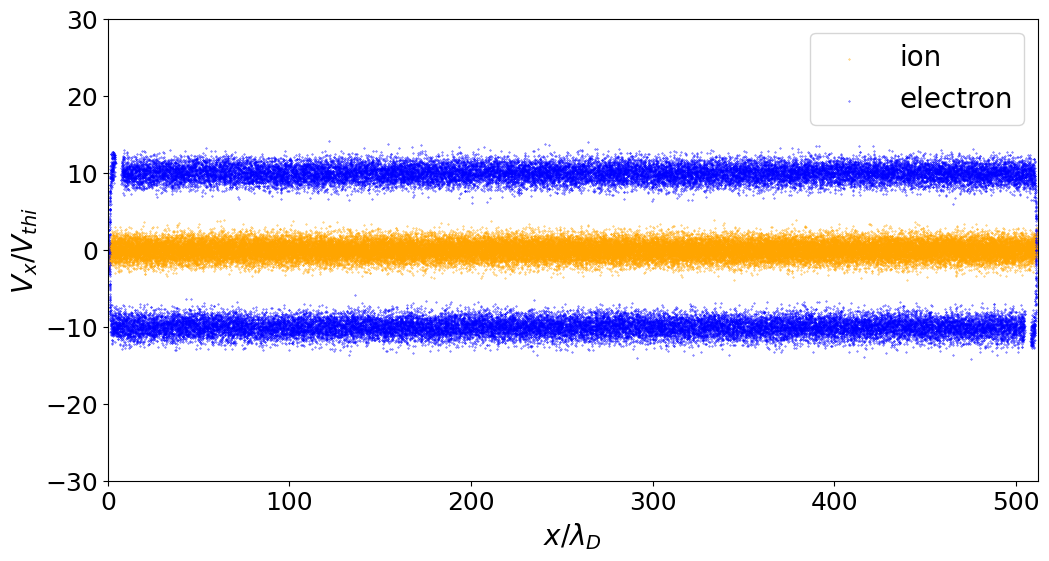

In [124]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

step = 200
x_ion = np.load(f"./results_two_stream_electron_open/x_ion_{step}.npy")
v_ion = np.load(f"./results_two_stream_electron_open/v_ion_{step}.npy")
x_electron = np.load(f"./results_two_stream_electron_open/x_electron_{step}.npy")
v_electron = np.load(f"./results_two_stream_electron_open/v_electron_{step}.npy")
num_ion = np.load(f"./results_two_stream_electron_open/num_ion_{step}.npy")
num_electron = np.load(f"./results_two_stream_electron_open/num_electron_{step}.npy")
ax.scatter(x_ion[0, :], v_ion[0, :]/v_thermal_ion, s=0.1, c='orange', label='ion')
ax.scatter(x_electron[0, :], v_electron[0, :]/v_thermal_electron, s=0.1, c='blue', label='electron')
ax.set_xlim(0, x_max)
ax.set_ylim(-30, 30)
ax.set_xlabel('$x / \lambda_D$', fontsize=20)
ax.set_ylabel('$V_x / V_{thi}$', fontsize=20)
ax.tick_params(labelsize=18)
ax.legend(loc='upper right', fontsize=20)
print(num_ion, num_electron)
    

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

interval = 1
number_of_results = 501
for i in range(number_of_results):
    results_total = np.load(f"./two_stream_electron/results_1pic_two_stream_electron_xv_{i}.npy")
    ax.clear()
    ax.scatter(results_total[0, :n_plus], results_total[3, :n_plus]/v_thermal_ion, s=0.1, c='orange', label='ion')
    ax.scatter(results_total[0, n_plus:n_plus+n_minus], results_total[3, n_plus:n_plus+n_minus]/v_thermal_electron, s=0.1, c='blue', label='electron(background)')
    ax.scatter(results_total[0, n_plus+n_minus:], results_total[3, n_plus+n_minus:]/v_thermal_electron, s=0.1, c='green', marker='*', label='electron(beam)')
    ax.set_xlim(0, x_max)
    ax.set_ylim(-30, 30)
    ax.set_xlabel('$x / \lambda_D$', fontsize=20)
    ax.set_ylabel('$V_x / V_{thi}$', fontsize=20)
    ax.tick_params(labelsize=18)
    ax.legend(loc='upper right', fontsize=20)
    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=f'two_stream_electron.mp4', fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(number_of_results):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()